In [2]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import seaborn as sns
import random
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchinfo import summary

In [10]:
root = './SIDD_Small_sRGB_Only/Data/'
dir = os.listdir(root[:-1])
folders=[]
for folder in dir:
  folders.append(folder)

GT = []
Noisy = []
for folder in folders:
  files = os.listdir(root+folder)
  for img in files:
    if img[0]=='G':
      GT.append(root+folder+'/'+img)
    else:
      Noisy.append(root+folder+'/'+img)

In [11]:
df = pd.DataFrame()
df['Ground Truth Images'] = GT
df['Noisy Images'] = Noisy
df.head()

Ground Truth Images  \
0  ./SIDD_Small_sRGB_Only/Data/0020_001_GP_00800_...   
1  ./SIDD_Small_sRGB_Only/Data/0072_003_IP_01000_...   
2  ./SIDD_Small_sRGB_Only/Data/0050_002_N6_03200_...   
3  ./SIDD_Small_sRGB_Only/Data/0040_002_IP_00800_...   
4  ./SIDD_Small_sRGB_Only/Data/0155_007_GP_00100_...   

                                        Noisy Images  
0  ./SIDD_Small_sRGB_Only/Data/0020_001_GP_00800_...  
1  ./SIDD_Small_sRGB_Only/Data/0072_003_IP_01000_...  
2  ./SIDD_Small_sRGB_Only/Data/0050_002_N6_03200_...  
3  ./SIDD_Small_sRGB_Only/Data/0040_002_IP_00800_...  
4  ./SIDD_Small_sRGB_Only/Data/0155_007_GP_00100_...

In [4]:
df.shape

(160, 2)

In [5]:
size=[]
for i in range(len(df)):
  img_gt = cv2.imread(df['Ground Truth Images'].iloc[i])
  size.append(img_gt.shape)

In [6]:
df['image size'] = size
df['image size'] = df['image size'].astype(str)
df.head()

Ground Truth Images  \
0  ./SIDD_Small_sRGB_Only/Data/0020_001_GP_00800_...   
1  ./SIDD_Small_sRGB_Only/Data/0072_003_IP_01000_...   
2  ./SIDD_Small_sRGB_Only/Data/0050_002_N6_03200_...   
3  ./SIDD_Small_sRGB_Only/Data/0040_002_IP_00800_...   
4  ./SIDD_Small_sRGB_Only/Data/0155_007_GP_00100_...   

                                        Noisy Images       image size  
0  ./SIDD_Small_sRGB_Only/Data/0020_001_GP_00800_...  (3044, 4048, 3)  
1  ./SIDD_Small_sRGB_Only/Data/0072_003_IP_01000_...  (3024, 4032, 3)  
2  ./SIDD_Small_sRGB_Only/Data/0050_002_N6_03200_...  (3120, 4208, 3)  
3  ./SIDD_Small_sRGB_Only/Data/0040_002_IP_00800_...  (3024, 4032, 3)  
4  ./SIDD_Small_sRGB_Only/Data/0155_007_GP_00100_...  (3044, 4048, 3)

In [7]:
X = df['Noisy Images']
y = df['Ground Truth Images']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(128,)
(128,)
(32,)
(32,)


In [11]:
def patches(img,patch_size):
  patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
  return patches

In [12]:
path = df['Ground Truth Images'].iloc[0]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_gt = patches(img,256)
print('Patch shape: {}'.format(patches_gt.shape))

Image shape: (3044, 4048, 3)
Patch shape: (11, 15, 1, 256, 256, 3)


In [13]:
path = df['Noisy Images'].iloc[0]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_nsy = patches(img,256)
print('Patch shape: {}'.format(patches_nsy.shape))

Image shape: (3044, 4048, 3)
Patch shape: (11, 15, 1, 256, 256, 3)


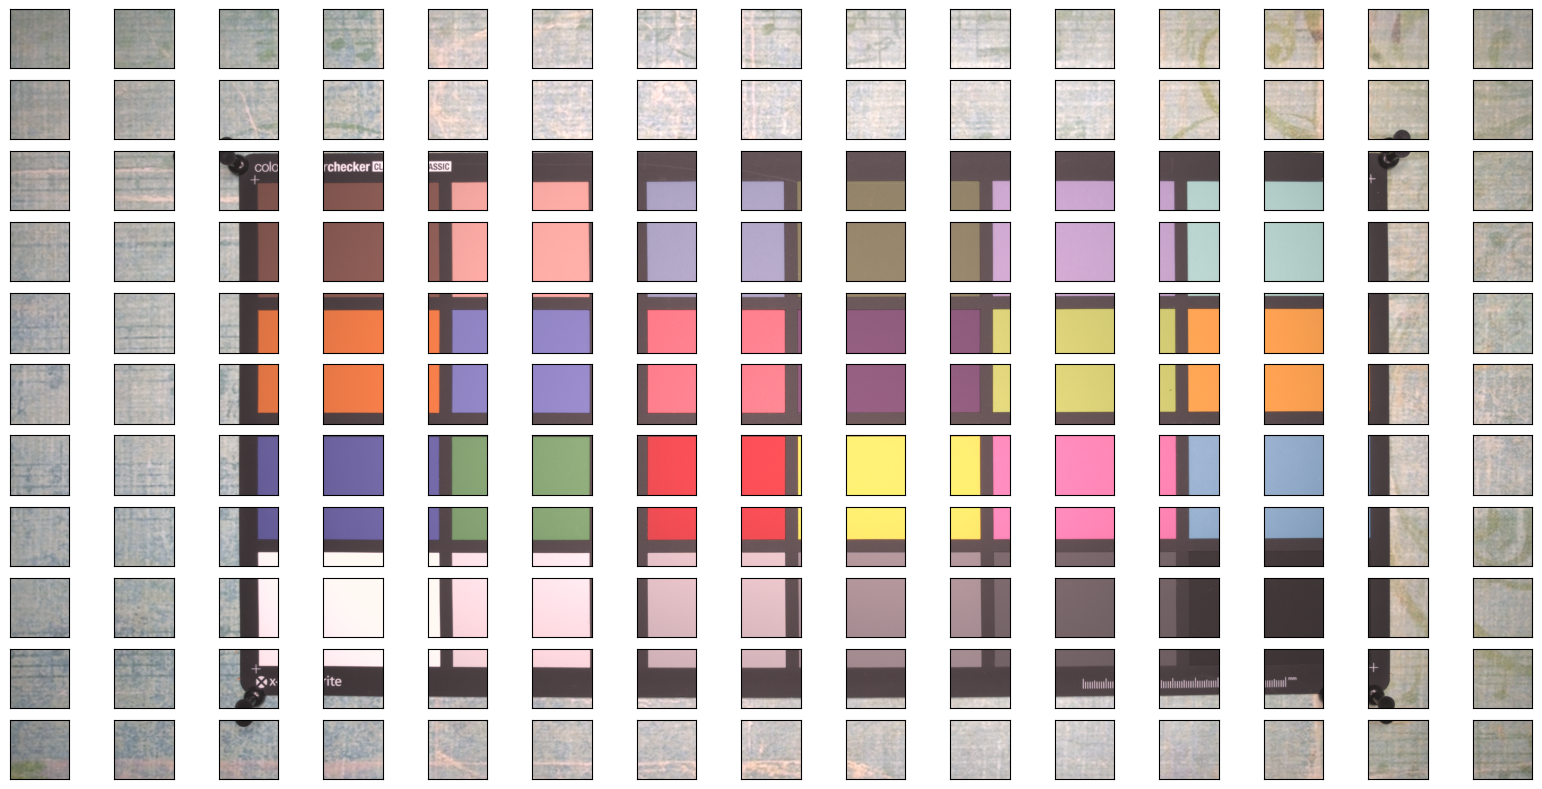

In [14]:
rows = patches_nsy.shape[0]
cols = patches_nsy.shape[1]
fig, axs = plt.subplots(rows,cols,figsize=(20,10))
for i in range(rows):
  for j in range(cols):
    axs[i][j].imshow(patches_gt[i][j][0])
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)

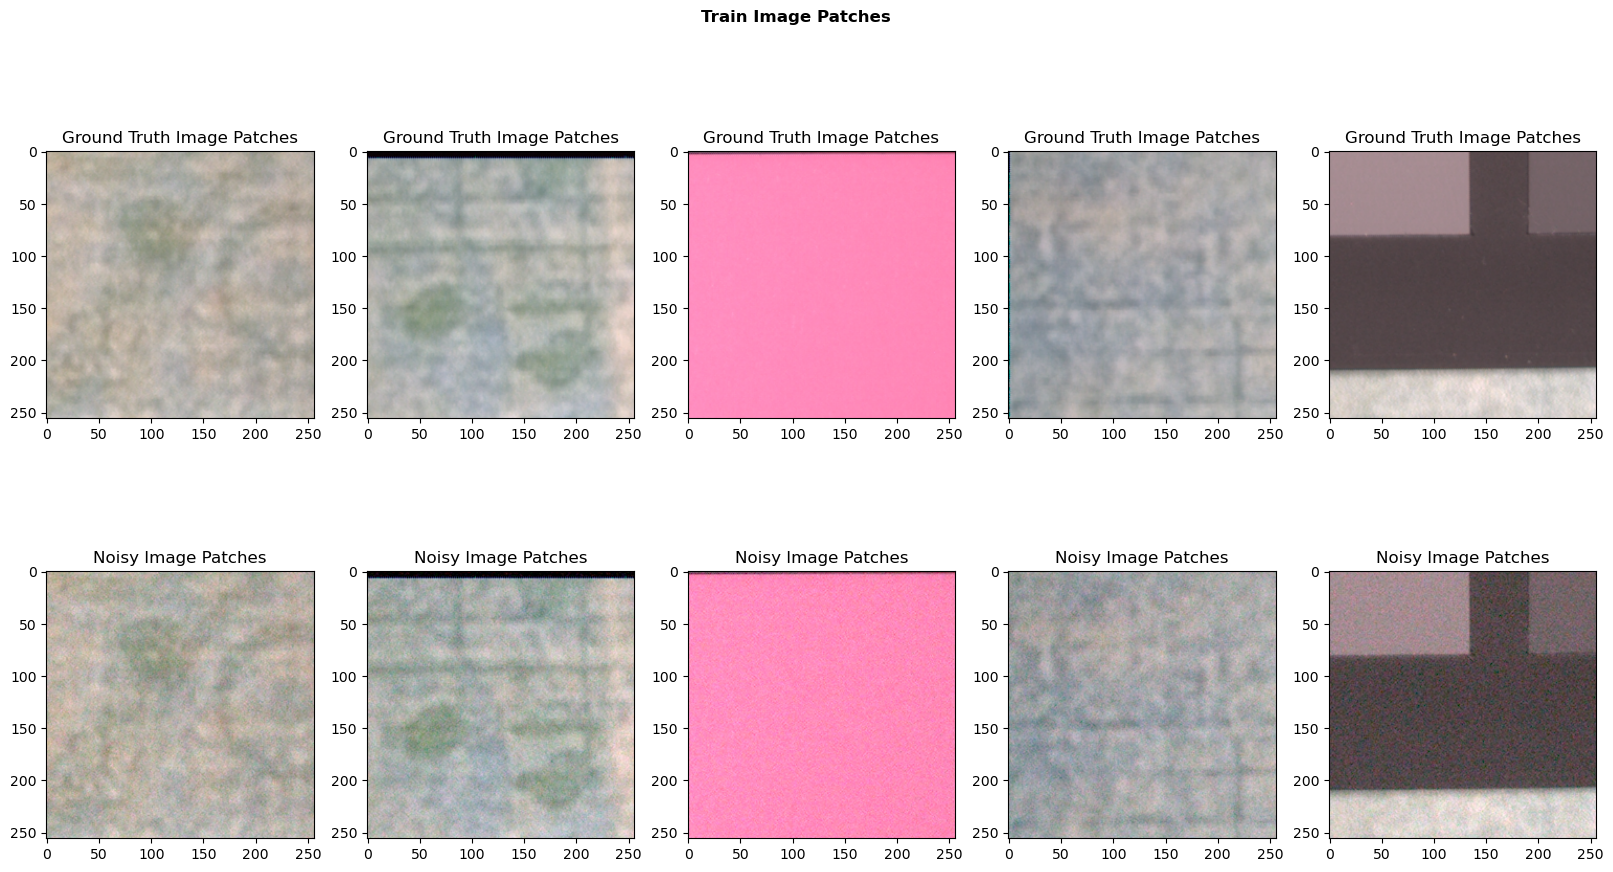

In [15]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, rows), 5)
c = random.sample(range(0, cols), 5)
fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(patches_gt[r[i]][c[i]][0])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(patches_nsy[r[i]][c[i]][0])
  axs[1][i].set_title('Noisy Image Patches')

In [16]:
#Creating patches for X_train and y_train
X_train_patches = []
y_train_patches = []
for i in range(len(X_train)):
  path = X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_train images
  patches_nsy = patches(img_nsy,256)
  
  path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_train images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_train_patches.append(patches_nsy[j][k][0])
      y_train_patches.append(patches_gt[j][k][0])
  
X_train_patches = np.array(X_train_patches)
y_train_patches = np.array(y_train_patches)

In [17]:
#Creating patches for X_test and y_test
X_test_patches = []
y_test_patches = []
for i in range(len(X_test)):
  path = X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_test images
  patches_nsy = patches(img_nsy,256)
  
  path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_test images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_test_patches.append(patches_nsy[j][k][0])
      y_test_patches.append(patches_gt[j][k][0])

X_test_patches = np.array(X_test_patches)
y_test_patches = np.array(y_test_patches)

In [18]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)

(2048, 256, 256, 3)
(2048, 256, 256, 3)
(512, 256, 256, 3)
(512, 256, 256, 3)


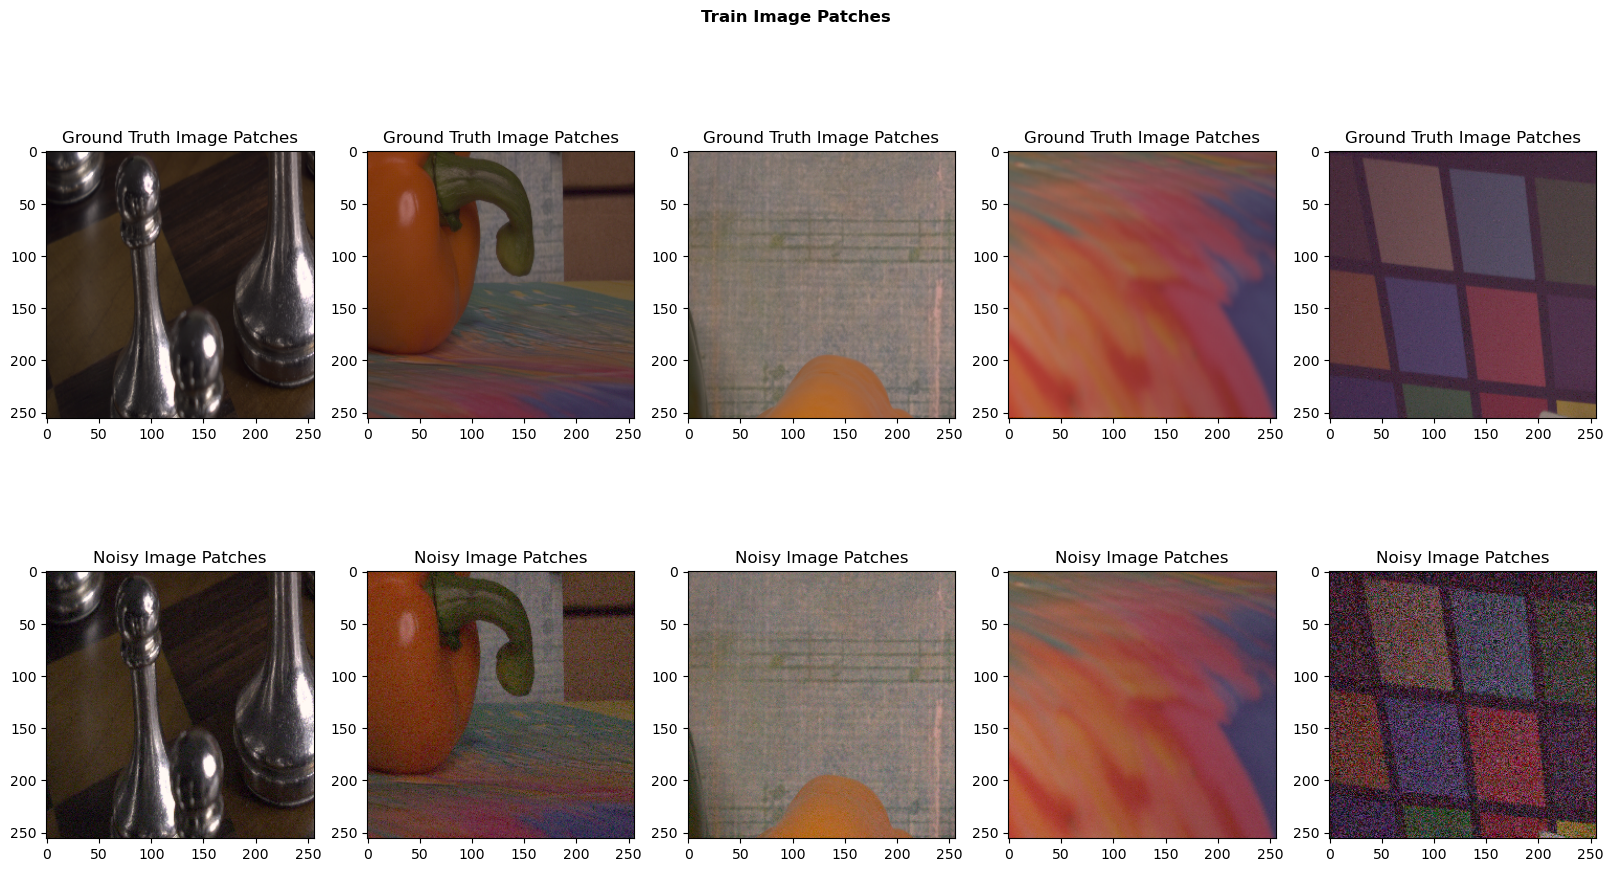

In [19]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, X_train_patches.shape[0]), 5)

fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_train_patches[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_train_patches[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

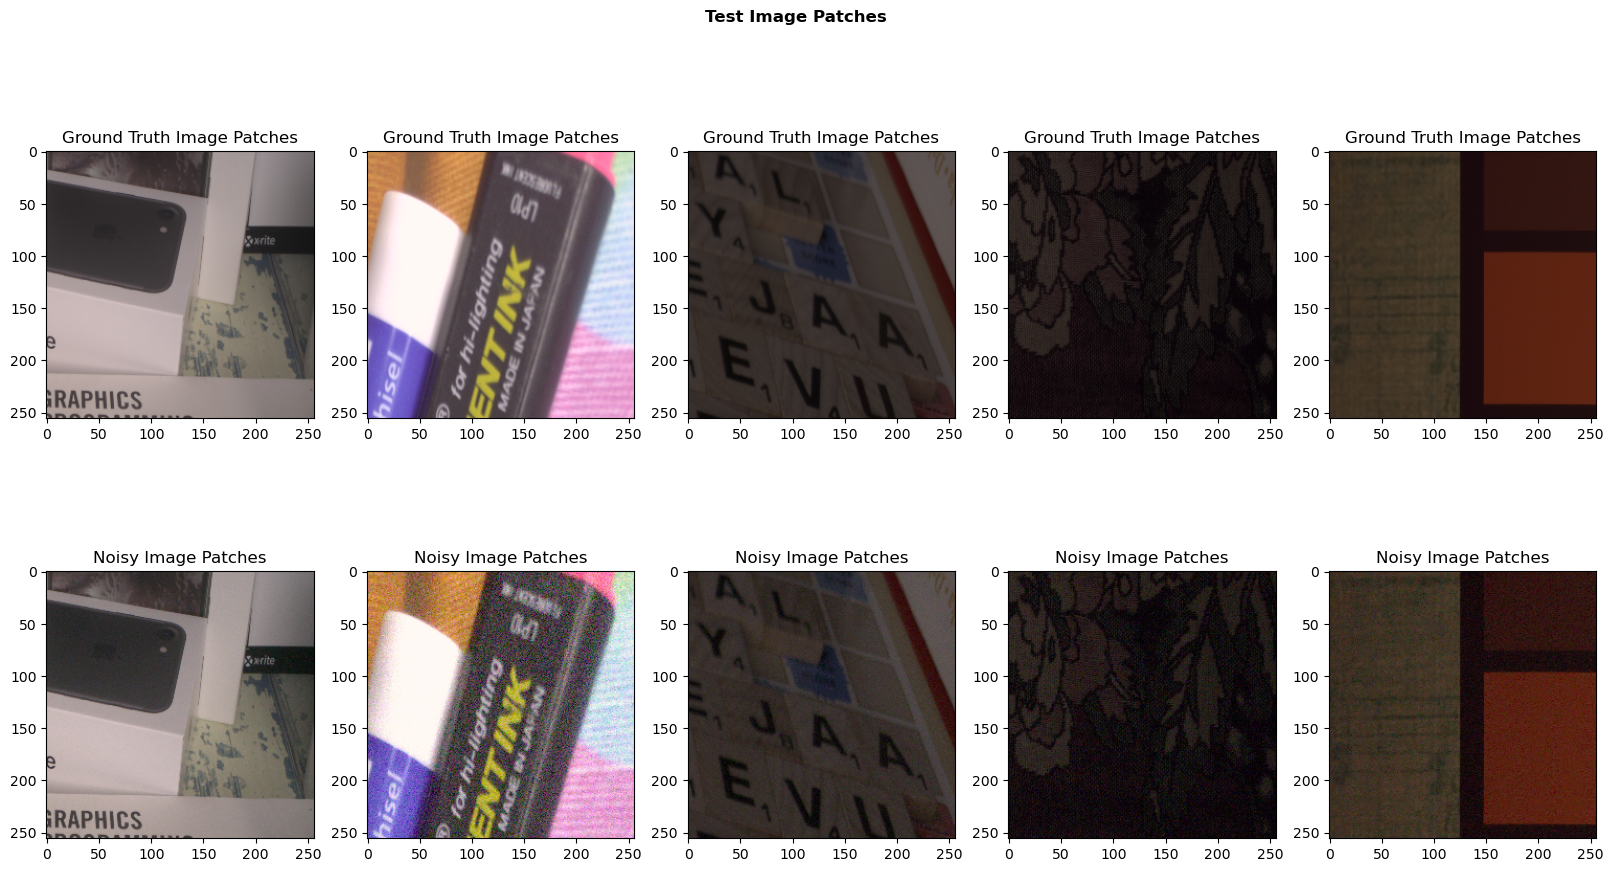

In [20]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, X_test_patches.shape[0]), 5)

fig.suptitle('Test Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_test_patches[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_test_patches[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

In [23]:
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

In [24]:
#Analyzing the PSNR and SSIM values of the images
from tqdm import tqdm
SSIM = [];PSNR = [];
for i in tqdm(range(len(df))):
    path = df['Ground Truth Images'].iloc[i]
    img1 = cv2.imread(path)
    img1 = img1.astype("float32") / 255.0
    path = df['Noisy Images'].iloc[i]
    img2 = cv2.imread(path)
    img2 = img2.astype("float32") / 255.0
    SSIM.append(ssim(img1,img2,multichannel=True,data_range=img2.max() - img2.min(),channel_axis=-1))
    PSNR.append(psnr(img1,img2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [12:29<00:00,  4.69s/it]


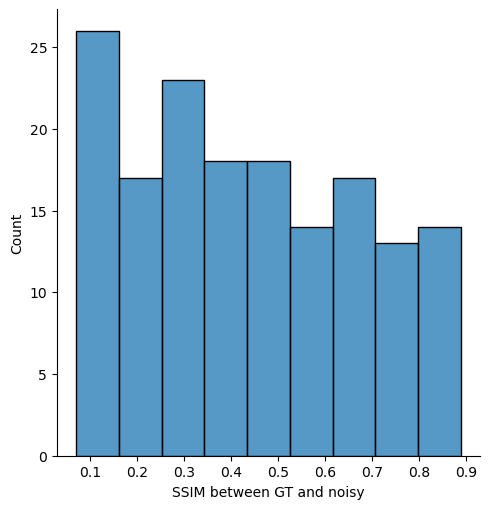

In [75]:
ax = sns.displot(SSIM)
ax.set(xlabel='SSIM between GT and noisy', ylabel='Count')

In [74]:
ssim_count = np.array(SSIM)
print(len(ssim_count),len(ssim_count[ssim_count > 0.56]))

160 49


In [26]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)

(2048, 256, 256, 3)
(2048, 256, 256, 3)
(512, 256, 256, 3)
(512, 256, 256, 3)


In [27]:
X_train_patches = np.transpose(X_train_patches, (0,3,1,2))
y_train_patches = np.transpose(y_train_patches, (0,3,1,2))
X_test_patches = np.transpose(X_test_patches, (0,3,1,2))
y_test_patches = np.transpose(y_test_patches, (0,3,1,2))

In [29]:
X_train_patches = X_train_patches.astype("float32") / 255.0
y_train_patches = y_train_patches.astype("float32") / 255.0
X_test_patches = X_test_patches.astype("float32") / 255.0
y_test_patches = y_test_patches.astype("float32") / 255.0

In [30]:
train_patches = TensorDataset(torch.Tensor(X_train_patches),torch.Tensor(y_train_patches))
test_patches = TensorDataset(torch.Tensor(X_test_patches),torch.Tensor(y_test_patches))

In [31]:
batch_size=32
train_loader = DataLoader(train_patches, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_patches, batch_size=batch_size, shuffle=True)

In [32]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,1,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,1,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(128,128,3,2,padding=1,output_padding=1),
            nn.ConvTranspose2d(128,64,3,2,padding=1,output_padding=1),
            nn.ConvTranspose2d(64,32,3,2,padding=1,output_padding=1),
            nn.Conv2d(32,3,3,1,padding='same'),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
model = AutoEncoder()
print(summary(model, input_size=(batch_size, 3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 128, 32, 32]         --
│    └─Conv2d: 2-1                       [32, 32, 256, 256]        896
│    └─ReLU: 2-2                         [32, 32, 256, 256]        --
│    └─MaxPool2d: 2-3                    [32, 32, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 64, 128, 128]        18,496
│    └─ReLU: 2-5                         [32, 64, 128, 128]        --
│    └─MaxPool2d: 2-6                    [32, 64, 64, 64]          --
│    └─Conv2d: 2-7                       [32, 128, 64, 64]         73,856
│    └─ReLU: 2-8                         [32, 128, 64, 64]         --
│    └─MaxPool2d: 2-9                    [32, 128, 32, 32]         --
├─Sequential: 1-2                        [32, 3, 256, 256]         --
│    └─ConvTranspose2d: 2-10             [32, 128, 64, 64]         147,584
│

In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=2,verbose=True)

In [35]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

count_parameters(model)

     864
      32
   18432
      64
   73728
     128
  147456
     128
   73728
      64
   18432
      32
     864
       3
________
  333955


# Train model

In [36]:
import time
start_time = time.time()

epochs = 15

train_losses = []
test_losses = []

for i in range(epochs):
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        #push data to GPU
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        # Apply the model
        pred = model(X_train)
        loss = criterion(pred, y_train)
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b % 16 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{32*b:6}/{X_train_patches.shape[0]}]  loss: {loss.item():10.8f}')

    train_losses.append(loss)
    
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            #push data to GPU
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            # Apply the model
            val = model(X_test)
            loss = criterion(val, y_test)
            test_losses.append(loss)
            scheduler.step(loss)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   16 [   512/2048]  loss: 0.01727368
epoch:  0  batch:   32 [  1024/2048]  loss: 0.01110071
epoch:  0  batch:   48 [  1536/2048]  loss: 0.00504483
epoch:  0  batch:   64 [  2048/2048]  loss: 0.00460452
epoch:  1  batch:   16 [   512/2048]  loss: 0.00507749
epoch:  1  batch:   32 [  1024/2048]  loss: 0.00639359
epoch:  1  batch:   48 [  1536/2048]  loss: 0.00376545
epoch:  1  batch:   64 [  2048/2048]  loss: 0.00392859
epoch:  2  batch:   16 [   512/2048]  loss: 0.00197802
epoch:  2  batch:   32 [  1024/2048]  loss: 0.00225392
epoch:  2  batch:   48 [  1536/2048]  loss: 0.00205862
epoch:  2  batch:   64 [  2048/2048]  loss: 0.00219434
epoch:  3  batch:   16 [   512/2048]  loss: 0.00221188
epoch:  3  batch:   32 [  1024/2048]  loss: 0.00196876
epoch:  3  batch:   48 [  1536/2048]  loss: 0.00188794
epoch:  3  batch:   64 [  2048/2048]  loss: 0.00170437
epoch:  4  batch:   16 [   512/2048]  loss: 0.00194699
epoch:  4  batch:   32 [  1024/2048]  loss: 0.00191862
epoch:  4 

PSNR before denoising : 23.942921155391836
PSNR after denoising : 23.81949735092022
SSIM before denoising : 0.4590433344274061
SSIM after denoising : 0.6211161054961849


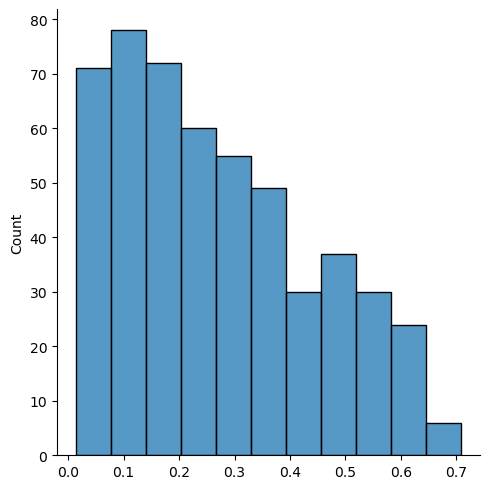

In [45]:
model.eval()
ssim_without_gt = []
ssim_wrt_gt = []
with torch.no_grad():
    psnr_nsy = 0.0
    psnr_de_nsy = 0.0
    ssim_nsy = 0.0
    ssim_de_nsy = 0.0
    
    for X_test, y_test in test_loader:
        X_test = X_test.cuda()
        y_test = y_test.cuda()
        
        y_val = model(X_test)
        # transform to image to compute PSNR

        for GT, NSY, PRED in zip(y_test, X_test, y_val):
            gt = np.transpose(GT.cpu().numpy(),(1,2,0))
            nsy = np.transpose(NSY.cpu().numpy(),(1,2,0))
            pred = np.transpose(PRED.cpu().numpy(),(1,2,0))
            
            psnr_nsy += psnr(gt,nsy,data_range=nsy.max() - nsy.min())
            psnr_de_nsy += psnr(gt,pred,data_range=pred.max() - pred.min())
            ssim_nsy += ssim(gt,nsy,data_range=nsy.max() - nsy.min(),channel_axis=-1)
            ssim_de_nsy += ssim(gt,pred,data_range=pred.max() - pred.min(),channel_axis=-1)
            ssim_without_gt.append(ssim(pred,nsy,data_range=pred.max() - pred.min(),channel_axis=-1))
            ssim_wrt_gt.append(ssim(pred,gt,data_range=pred.max() - pred.min(),channel_axis=-1))
    dataset_size = 512
    psnr_nsy = psnr_nsy/dataset_size
    psnr_de_nsy = psnr_de_nsy/dataset_size
    ssim_nsy = ssim_nsy/dataset_size
    ssim_de_nsy = ssim_de_nsy/dataset_size

print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)
sns.displot(ssim_without_gt)

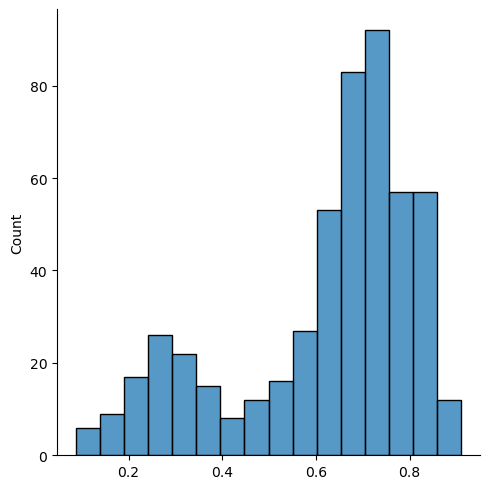

In [46]:
sns.displot(ssim_wrt_gt)

In [64]:
ssim_without_gt_np = np.array(ssim_without_gt)
ssim_wrt_gt_np = np.array(ssim_wrt_gt)
max_acc = -1
max_acc_th = -1

def calc_metrics(tp,tn,fp,fn):
    acc = (tp + tn)/(tp+tn+fp+fn)
    recall = tp/(tp+fn)
    prec = tp/(tp+fp)
    f1 = 2*tp/(2*tp+fp+fn)
    return acc, recall, prec, f1

In [77]:
for threshold in np.arange(1,0,-0.01):
    tn = len(ssim_without_gt_np[ssim_without_gt_np < threshold])
    tp = len(ssim_wrt_gt_np[ssim_wrt_gt_np > threshold])
    fn = len(ssim_wrt_gt_np[ssim_wrt_gt_np < threshold])
    fp = len(ssim_without_gt_np[ssim_without_gt_np > threshold])
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    if accuracy >= max_acc:
        max_acc = accuracy
        max_acc_th = np.round(threshold,2)

In [78]:
tn = len(ssim_without_gt_np[ssim_without_gt_np < max_acc_th])
tp = len(ssim_wrt_gt_np[ssim_wrt_gt_np > max_acc_th])
fn = len(ssim_wrt_gt_np[ssim_wrt_gt_np < max_acc_th])
fp = len(ssim_without_gt_np[ssim_without_gt_np > max_acc_th])
accuracy, recall, precision, f1 = calc_metrics(tp,tn,fp,fn)
print(np.round(max_acc_th,2))
print("Accuracy: ",accuracy)
print("Recall: ",recall)
print("Precision: ",precision)
print("F1: ",f1)

0.56
Accuracy:  0.8310546875
Recall:  0.7421875
Precision:  0.9026128266033254
F1:  0.8145766345123259
